In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '..')

import numpy as np

from batchflow import Pipeline, B, V, I, M, C, plot
from batchflow.models.torch import TorchModel

from src.loader import ImagesDataset

/Users/gorya/Code/style_ken/notebooks/../batchflow/batchflow/plotter/cmaps.py:8: UserWarning: Trying to register the cmap 'batchflow' which already exists.
  register_cmap('batchflow', BATCHFLOW_CMAP)


In [3]:
seed = 11
rng = np.random.default_rng(seed)

In [4]:
%%time

DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=seed)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

CPU times: user 28.1 s, sys: 1.14 s, total: 29.2 s
Wall time: 29.7 s


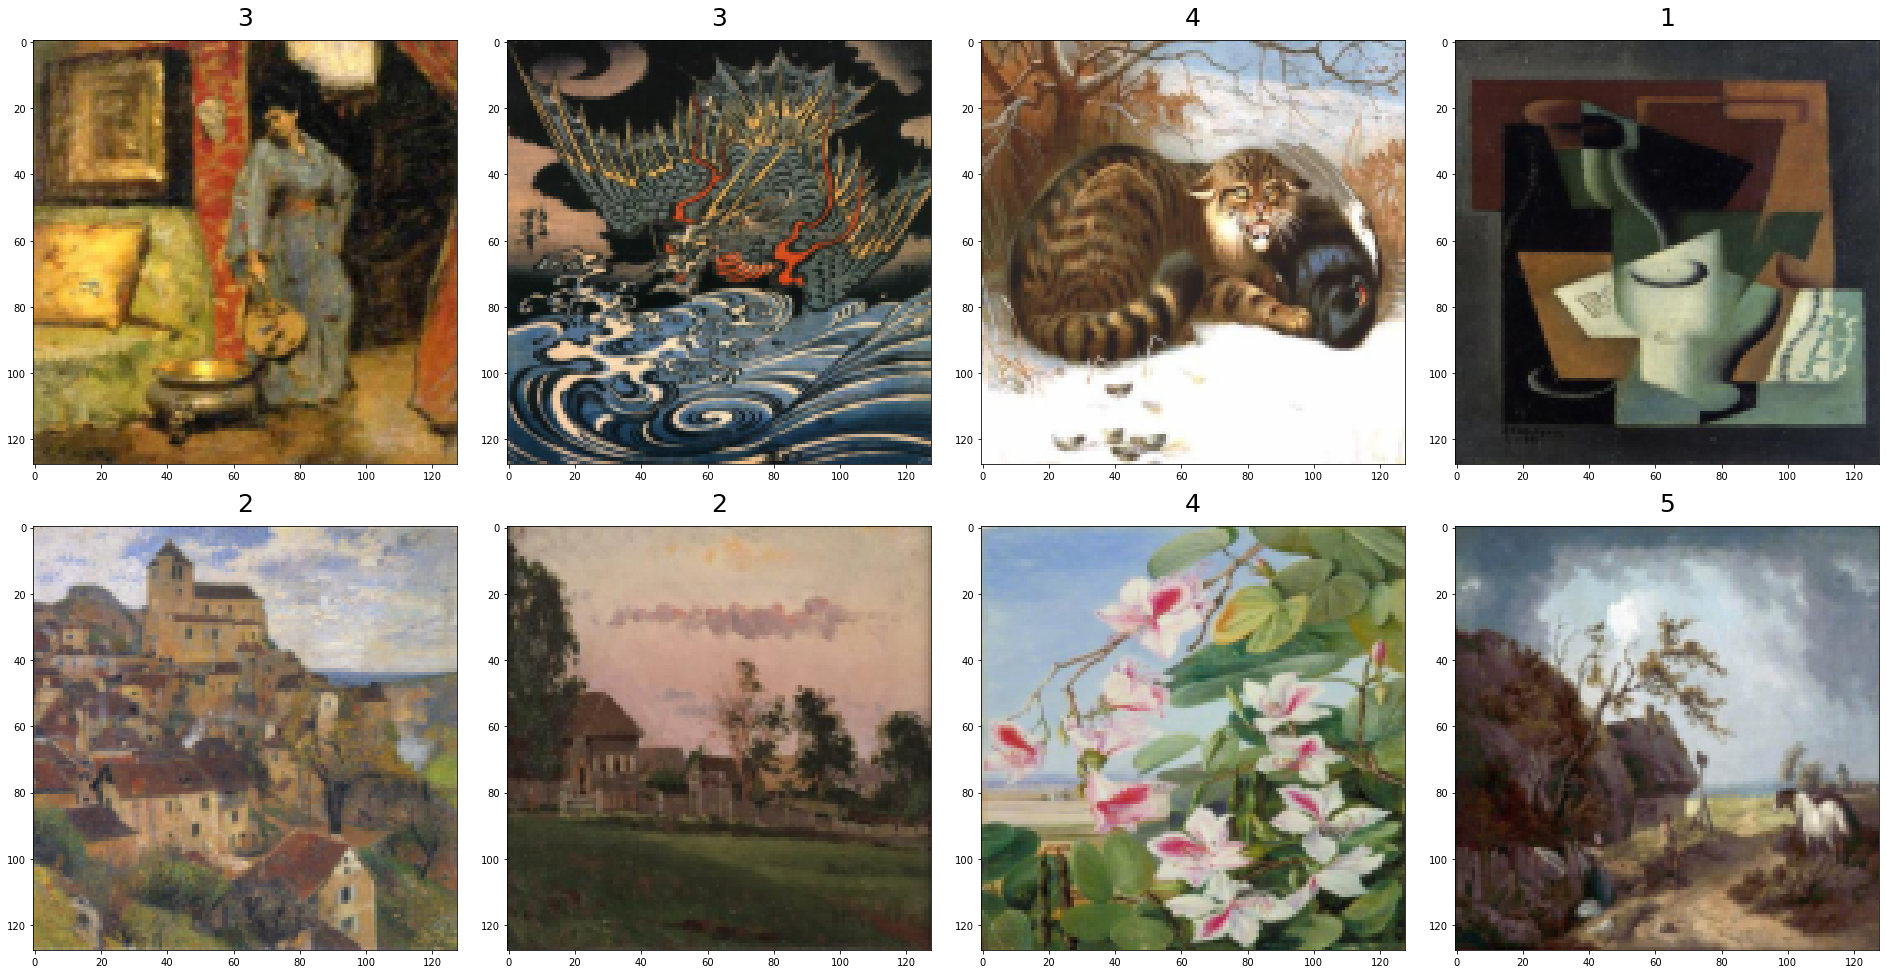

In [5]:
indices = rng.choice(range(dataset.size), 8)
images = list(dataset.images[indices])
labels = list(dataset.labels[indices])
plot(data=images, title=labels, combine='separate')

In [37]:
model_config = {
    # Model info:
    'inputs/shapes': np.prod(SHAPE),
    'head/classes': n_classes,

    # Model architecture:
#     'initial_block' : {},
#     'body' : {'layout': 'f'},
    'head' : {'layout': 'f'},

    # Model training details:
    'init_model_weights': 'xavier',
    'loss': 'ce',
    'optimizer': 'Adam',
    'decay': {'name': 'exp', 'frequency': 500},
    'output': {'predicted': ['proba', 'labels']},
    'device': 'cpu'
}

In [38]:
def flatten(batch, src, dst):
    data = getattr(batch, src)
    data = data.reshape(data.shape[0], -1)
    setattr(batch, dst, data)

def evaluate(iteration, frequency, model, metrics, agg, history):
    if (iteration - 1) % frequency == 0:
        infer_pipeline = infer_template << dataset.test << {'model': model}
        infer_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False)
        metrics_value = infer_pipeline.v('metrics').evaluate(metrics=metrics, agg=agg)
        return metrics_value
    return history[-1]
        
train_template = (
    Pipeline()
    .flatten(B(), src='images', dst='inputs')
    .init_variable(name='loss_history', default=[])
    .init_variable(name='test_metrics', default=[])
    .init_model(name='model', model_class=TorchModel, mode='dynamic', config=model_config)
    .train_model(name='model', inputs=B('inputs'), targets=B('labels'),
                 outputs='loss', save_to=V('loss_history', mode='a'))
    .call(evaluate, iteration=I(), model=M('model'), frequency=C('evaluate/frequency'),
          metrics=C('evaluate/metrics'), agg=C('evaluate/metrics'),
          history=V('test_metrics'), save_to=V('test_metrics', mode='a'))
)

infer_template = (
    Pipeline()
    .flatten(B(), src='images', dst='inputs')
    .init_variables('proba', 'predictions', 'metrics')
    .import_model('model', C('model'))
    .predict_model(name='model', inputs=B('inputs'),
                   outputs=['predicted_proba', 'predictions'],
                   save_to=[V('proba'), V('predictions')])
    .gather_metrics('classification', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', num_classes=n_classes,
                    axis=1, save_to=V('metrics', mode='update'))
)

train_config = {
    'evaluate': {
        'frequency': 50,
        'metrics': 'accuracy',
    }
}

train_pipeline = train_template << dataset.train << train_config

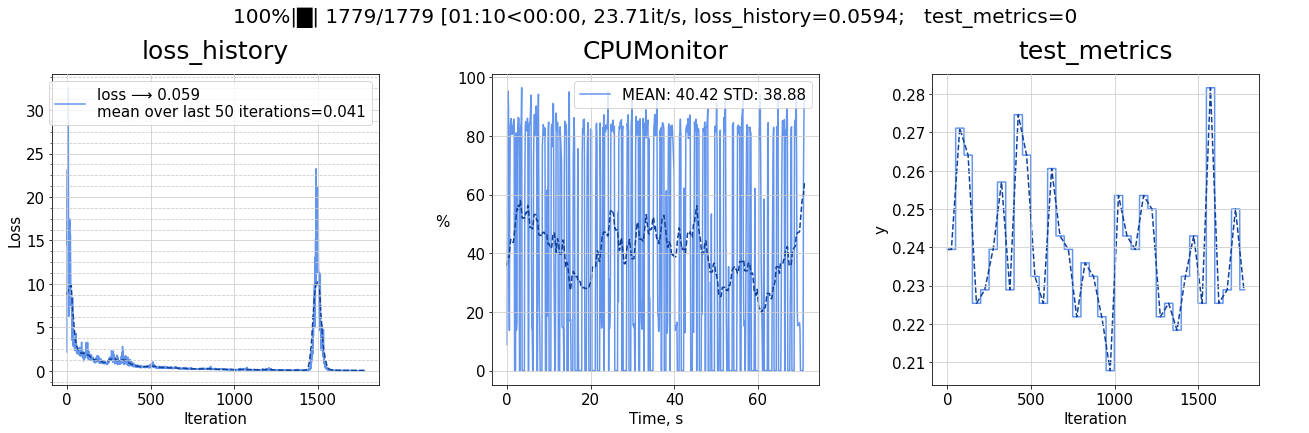

Exception ignored in: <function ResourceMonitor.__del__ at 0x16da07b80>
Traceback (most recent call last):
  File "/Users/gorya/Code/style_ken/notebooks/../batchflow/batchflow/monitor.py", line 88, in __del__
    super().__del__()
AttributeError: 'super' object has no attribute '__del__'


In [39]:
BATCH_SIZE = 128
FREQUENCY = 50
EPOCH_NUM = 200

notifier = {
    'bar': 'n', 'frequency': FREQUENCY,
    'graphs': ['loss_history', 'cpu', 'test_metrics'],
}

_ = train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=EPOCH_NUM, shuffle=True, notifier=notifier)

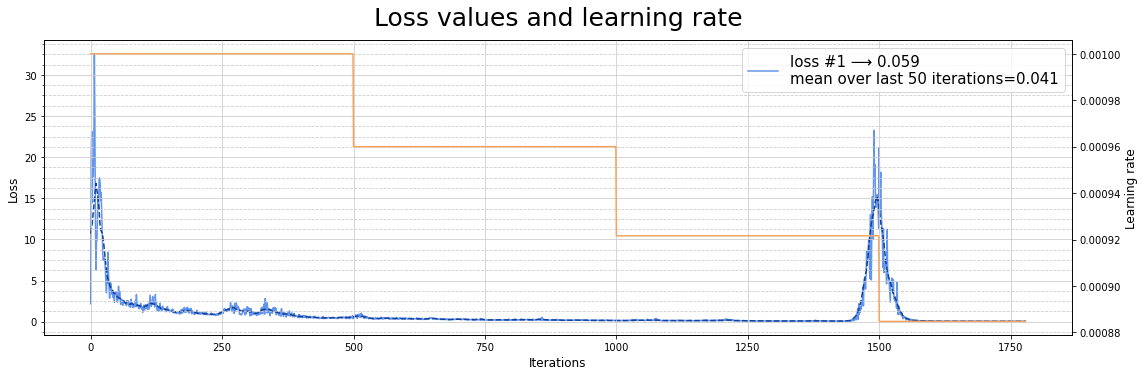

In [40]:
train_pipeline.model.plot_loss()

In [41]:
infer_pipeline = infer_template << dataset.test << {'model': train_pipeline.model}

In [42]:
infer_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False, bar='t')

 ... (more hidden) ...


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


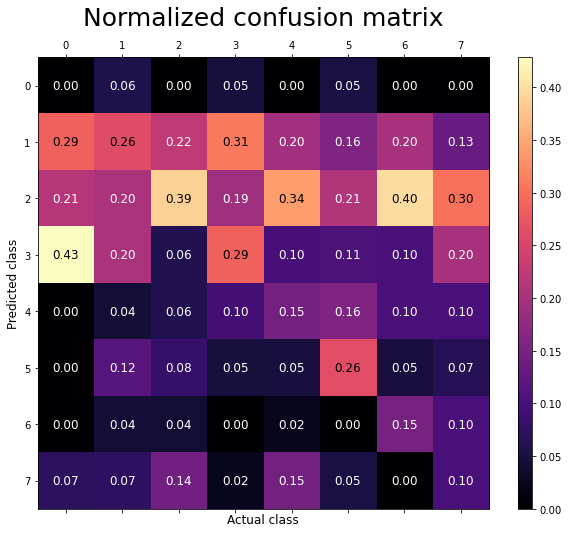

In [43]:
infer_pipeline.v('metrics').plot_confusion_matrix(normalize=True)

In [44]:
import pandas as pd

In [45]:
metrics = infer_pipeline.v('metrics').evaluate(['precision', 'recall'], multiclass=None)
pd.DataFrame(metrics).style.background_gradient('RdYlGn')

,precision,recall
0,0.000000,0.000000
1,0.276923,0.260870
2,0.240506,0.387755
3,0.244898,0.285714
4,0.250000,0.146341
5,0.208333,0.263158
6,0.250000,0.150000
7,0.125000,0.100000
